### Make sure GPU is on

https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
import tensorflow_datasets as tfds
import random 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.util import montage

### (10 pts.) Prepare the datasets

#### load the plant_village data from tensorflow_datasets. Split by %80-10-10 train-val-test using split= input.

#### Please check https://www.tensorflow.org/datasets/splits

In [3]:
raw_test,test_info = tfds.load('plant_village', split='train[:10%]',as_supervised=True,with_info=True)#### fill here
raw_val = tfds.load('plant_village', split='train[10%:20%]',as_supervised=True)#### fill here
raw_train = tfds.load('plant_village',split='train[20%:]',as_supervised=True) #### fill here

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/plant_village/1.0.0.incompleteIUH8L6/plant_village-train.tfrecord


Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.0. Subsequent calls will reuse this data.


#### Normalize each image into [0,1] range, shuffle and minibatch 128.

In [0]:
pp_test = raw_test.map(lambda img, label:(tf.image.convert_image_dtype(img/255, tf.float32), label)).shuffle(1024).batch(128)
pp_val = raw_val.map(lambda img,label:(tf.image.convert_image_dtype(img/255, tf.float32), label)).shuffle(1024).batch(128)
pp_train = raw_train.map(lambda img,label:(tf.image.convert_image_dtype(img/255, tf.float32), label)).shuffle(1024).batch(128)

#### Display the examples from the dataset.

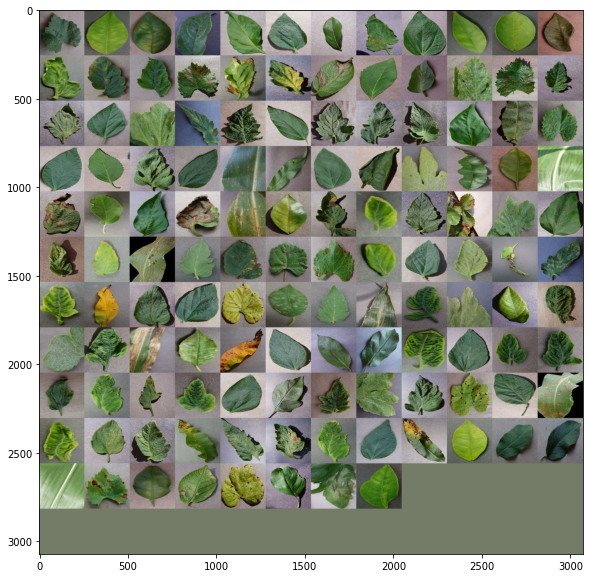

In [5]:
plt.figure(figsize=(10,10))
for example in pp_train.take(1):  # Only take a single example
  image, label = example[0], example[1]
  plt.imshow(montage(image, multichannel=True))

### (20 pts) The Fully Connected Neural Network implementation

#### It is a 4 layer (Fully Connected) Neural Network. The feature depths are [512,256,128] and last softmax layer has 38 output. Train for 10 epochs, with 0.001 learning rate and categorical cross entropy.

In [6]:
model = tf.keras.models.Sequential([                                                              
  ### Flatten
  tf.keras.layers.Flatten(input_shape=(256,256,3)),
  ### Dense
  tf.keras.layers.Dense(512,activation='relu',name='layer1'),
  ### Dense
  tf.keras.layers.Dense(256,activation='relu',name='layer2'),
  ### Dense
  tf.keras.layers.Dense(128,activation='relu',name='layer3'),
  ### Dense softmax
  tf.keras.layers.Dense(38,activation='softmax',name='layer_output')

])

model.compile(
    ### loss function sparse_categorical_crossentropy
    loss='sparse_categorical_crossentropy',
    ### Adam optimizer
    optimizer=tf.keras.optimizers.Adam(),
    ### metrics
    metrics=['sparse_categorical_accuracy','accuracy']
)

history = model.fit(
    pp_train,
    batch_size=128,
    epochs=10,
    validation_data=pp_val
)

Epoch 1/10
340/340 [==============================] - 56s 164ms/step - loss: 9.3344 - sparse_categorical_accuracy: 0.2653 - accuracy: 0.2653 - val_loss: 2.7081 - val_sparse_categorical_accuracy: 0.3567 - val_accuracy: 0.3567
Epoch 2/10
340/340 [==============================] - 56s 165ms/step - loss: 2.1618 - sparse_categorical_accuracy: 0.4177 - accuracy: 0.4177 - val_loss: 2.0163 - val_sparse_categorical_accuracy: 0.4495 - val_accuracy: 0.4495
Epoch 3/10
340/340 [==============================] - 56s 166ms/step - loss: 1.8322 - sparse_categorical_accuracy: 0.4872 - accuracy: 0.4872 - val_loss: 1.6703 - val_sparse_categorical_accuracy: 0.5292 - val_accuracy: 0.5292
Epoch 4/10
340/340 [==============================] - 56s 165ms/step - loss: 1.6061 - sparse_categorical_accuracy: 0.5405 - accuracy: 0.5405 - val_loss: 1.8110 - val_sparse_categorical_accuracy: 0.5069 - val_accuracy: 0.5069
Epoch 5/10
340/340 [==============================] - 56s 166ms/step - loss: 1.4783 - sparse_categor

#### Plot training & validation accuracy values

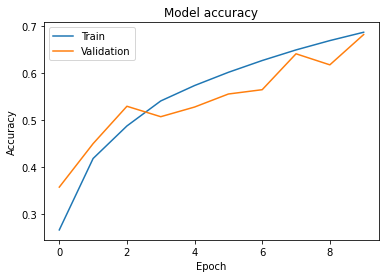

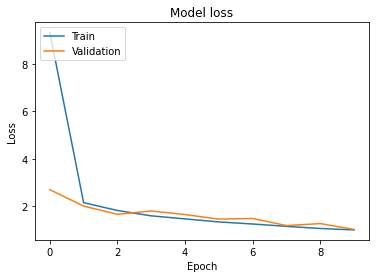

In [7]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Calculate test set

In [8]:
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model.evaluate(pp_test)
print('test loss, test acc:', results)


# Evaluate on test data
43/43 [==============================] - 5s 121ms/step - loss: 1.0274 - sparse_categorical_accuracy: 0.6860 - accuracy: 0.6860
test loss, test acc: [1.0273516178131104, 0.6860036849975586, 0.6860036849975586]


### (20 pts.) The Convolutional Neural Network implementation

#### It is a 4 layer Convolutional Neural Network. First two layers are Convolutional and last two layers are Fully Connected. The depths are [64,128,64] and the last softmax layer has 38 output. Train for 10 epochs, with 0.001 learning rate and categorical cross entropy.

In [9]:
model_cnn = tf.keras.models.Sequential([
  ### Conv2D layer
  tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, activation='relu', input_shape=(256,256,3)),
  ### MaxPooling2D layer
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=1, padding='same'),
  ### Conv2D layer
   tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, activation='relu'),
  ### MaxPooling2D layer
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=1, padding='same'),
  ### Flatten
  tf.keras.layers.Flatten(),
  ### Dense
  tf.keras.layers.Dense(64, activation='relu'),
  ### Dense softmax
  tf.keras.layers.Dense(38, activation='softmax')
])

model_cnn.compile(
    ### loss function sparse_categorical_crossentropy
    loss='sparse_categorical_crossentropy',
    ### Adam optimizer
    optimizer=tf.keras.optimizers.Adam(),
    ### metrics
    metrics=['sparse_categorical_accuracy','accuracy']
)

history_cnn = model_cnn.fit(
    pp_train,
    epochs=10,
    validation_data=pp_val,
)

Epoch 1/10
340/340 [==============================] - 119s 351ms/step - loss: 2.6814 - sparse_categorical_accuracy: 0.5573 - accuracy: 0.5573 - val_loss: 0.9333 - val_sparse_categorical_accuracy: 0.7284 - val_accuracy: 0.7284
Epoch 2/10
340/340 [==============================] - 118s 348ms/step - loss: 0.6396 - sparse_categorical_accuracy: 0.8109 - accuracy: 0.8109 - val_loss: 0.6502 - val_sparse_categorical_accuracy: 0.8098 - val_accuracy: 0.8098
Epoch 3/10
340/340 [==============================] - 118s 348ms/step - loss: 0.3316 - sparse_categorical_accuracy: 0.8967 - accuracy: 0.8967 - val_loss: 0.6748 - val_sparse_categorical_accuracy: 0.8262 - val_accuracy: 0.8262
Epoch 4/10
340/340 [==============================] - 118s 347ms/step - loss: 0.1988 - sparse_categorical_accuracy: 0.9362 - accuracy: 0.9362 - val_loss: 0.7128 - val_sparse_categorical_accuracy: 0.8299 - val_accuracy: 0.8299
Epoch 5/10
340/340 [==============================] - 118s 346ms/step - loss: 0.1178 - sparse_ca

#### Plot training & validation accuracy values

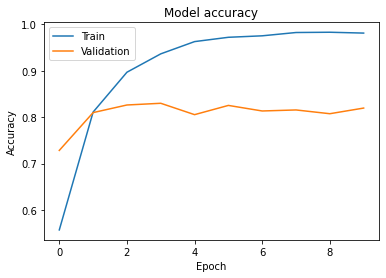

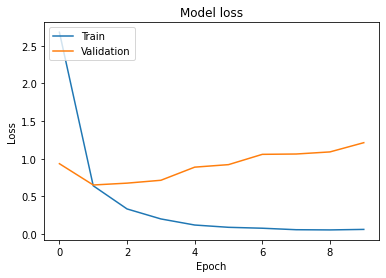

In [10]:
# Plot training & validation accuracy values
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### Calculate test set

In [11]:
# Evaluate the model on the test data using `evaluate`
print('\n# Evaluate on test data')
results = model_cnn.evaluate(pp_test)
print('test loss, test acc:', results)


# Evaluate on test data
43/43 [==============================] - 8s 180ms/step - loss: 1.0772 - sparse_categorical_accuracy: 0.8284 - accuracy: 0.8284
test loss, test acc: [1.0772494077682495, 0.8283609747886658, 0.8283609747886658]
